In [112]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,KFold, cross_val_score,cross_validate,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from time import time
import joblib

## Data Import & Exploration

In [113]:
# Switching to the source directory

project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
project_root
print(project_root)

C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_predictor


In [114]:
# YAML Loading
import yaml

yaml_path = os.path.abspath(os.path.join(os.getcwd(), "../", 'config', 'config.yaml'))
print('YAML Path ->', yaml_path)

with open(yaml_path, "r") as f:
    config_yaml = yaml.safe_load(f)
    config_yaml_datasource = config_yaml['datasource']
    
print("**"*50)
print(config_yaml_datasource)

YAML Path -> C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_predictor\config\config.yaml
****************************************************************************************************
{'root_folder': 'data', 'folders': {'raw': 'raw', 'processed': 'processed'}, 'files': {'main': {'filename': 'premiums_main.xlsx', 'processed_name': 'premiums_main_processed.csv'}, 'rest': {'filename': 'premiums_rest.xlsx', 'processed_name': 'premiums_rest_processed_with_gr.csv'}, 'young': {'filename': 'premiums_young.xlsx', 'processed_name': 'premiums_young_processed.csv'}, 'young_gr': {'filename': 'premiums_young_with_gr.xlsx', 'processed_name': 'premiums_young_processed_with_gr.csv'}}}


In [115]:
# Define datasource path

folder = config_yaml_datasource['root_folder']
sub_folder = config_yaml_datasource['folders']['raw']
file = config_yaml_datasource['files']['young_gr']['filename']

datasource_path = os.path.abspath(os.path.join(project_root,folder,sub_folder,file))
datasource_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_predictor\\data\\raw\\premiums_young_with_gr.xlsx'

In [116]:
# Reading the data

df = pd.read_excel(datasource_path,sheet_name='Sheet1')

In [117]:
# Displaying the data

df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [118]:
df.shape

(20096, 14)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096 entries, 0 to 20095
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20096 non-null  int64 
 1   Gender                 20096 non-null  object
 2   Region                 20096 non-null  object
 3   Marital_status         20096 non-null  object
 4   Number Of Dependants   20096 non-null  int64 
 5   BMI_Category           20096 non-null  object
 6   Smoking_Status         20094 non-null  object
 7   Employment_Status      20095 non-null  object
 8   Income_Level           20092 non-null  object
 9   Income_Lakhs           20096 non-null  int64 
 10  Medical History        20096 non-null  object
 11  Insurance_Plan         20096 non-null  object
 12  Annual_Premium_Amount  20096 non-null  int64 
 13  Genetical_Risk         20096 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 2.1+ MB


## Data Cleaning

The following steps were performed during data cleaning:

- Handling missing values
- Removing duplicated rows
- Formatting numeric and categorical values
- Treating outliers to improve data quality

### Column Formatter

In [120]:
# Renaming the columns with proper formatter
# Eg: Number Of Dependants -> number_of_dependants

df.columns = df.columns.str.replace(' ','_').str.lower()

In [121]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


### Handling Missing Values

In [122]:
# Finding the columns with NA values

df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [123]:
# Dropping the Rows where it has NA value

# Before Dropping
df[df['smoking_status'].isna()].head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
6853,23,Male,Southwest,Unmarried,0,Normal,NaN,Freelancer,<10L,3,No Disease,Bronze,6001,2
7757,19,Female,Northeast,Unmarried,0,Normal,NaN,Salaried,10L - 25L,23,No Disease,Bronze,9010,5


Since the count is low, the rows containing at least one missing value were dropped.

In [124]:
# Dropping
df.dropna(how='any',inplace = True)

In [125]:
# After Dropping
df[df['smoking_status'].isna()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


In [126]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [127]:
df.reset_index(inplace=True,drop=True)

### Handling Duplicated Rows

In [128]:
# Duplicated rows

df[df.duplicated()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


Although there are no duplicated rows, they are being dropped as a precautionary measure.

In [129]:
# Dropping the duplicated rows

df.drop_duplicates(inplace=True)

### Fomatting Values - Numeric Columns

In [130]:
df.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
genetical_risk            int64
dtype: object

In [131]:
# Selecting only the columns with numerical values

numeric_columns = df.select_dtypes(include=['int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

In [132]:
# Printing the unique values of each numeric columns to identify the values with improper formats

for col in numeric_columns:
    print(f'{col}:\n',df[col].unique())
    print('*'*100)

age:
 [18 22 21 25 20 19 23 24]
****************************************************************************************************
number_of_dependants:
 [ 0  2  1  3 -3 -1]
****************************************************************************************************
income_lakhs:
 [ 99   3  97  15  14  30   8   5  18  70  33  29   4   1  19  27  38  39
  20  36  16  92  22   9  57  24  49  52  90   2  10  21  88  11  13  25
  26  12   6  64  40  50  35  86  34  41  98  23   7  44  37  17  31  80
  81  32  46  85  58  42  28  61  78  75  51  65  43  84  71  73  66  53
  59  48  95  47  69  54  62  89  72  93  68  63  45  56  91  82  96  74
  79  67  77  60  76 100  87  55  83  94 440 580 700 790]
****************************************************************************************************
annual_premium_amount:
 [13365 11050 11857 ...  6585  9783 14498]
****************************************************************************************************
genetical_risk:
 

The negative values in `number_of_dependents` should be handled by converting them to their absolute values.

In [133]:
# Before formatting

df['number_of_dependants'].unique()

array([ 0,  2,  1,  3, -3, -1])

In [134]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [135]:
# After formatting

df['number_of_dependants'].unique()

array([0, 2, 1, 3])

### Fomatting Values - Categorical Columns

In [136]:
# Selecting only the columns with categorical values

cat_columns = df.select_dtypes(include=['object']).columns
cat_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [137]:
# Printing the unique values of each categorical columns to identify the values with improper formats

for col in cat_columns:
    print(f'{col}:\n',list(df[col].unique()))
    print('*'*100)

gender:
 ['Male', 'Female']
****************************************************************************************************
region:
 ['Northeast', 'Northwest', 'Southeast', 'Southwest']
****************************************************************************************************
marital_status:
 ['Unmarried', 'Married']
****************************************************************************************************
bmi_category:
 ['Overweight', 'Underweight', 'Normal', 'Obesity']
****************************************************************************************************
smoking_status:
 ['Regular', 'No Smoking', 'Occasional', 'Smoking=0', 'Does Not Smoke', 'Not Smoking']
****************************************************************************************************
employment_status:
 ['Self-Employed', 'Freelancer', 'Salaried']
****************************************************************************************************
income_level:
 ['> 40L', '<10

As indicated by the above result, the `smoking_status` column contains multiple values with the same meaning; therefore, this column will be formatted.

In [138]:
# Before formatting

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional', 'Smoking=0',
       'Does Not Smoke', 'Not Smoking'], dtype=object)

In [139]:
# Replacing values with desired formats

df['smoking_status'] = df['smoking_status'].replace(
    {
       'Smoking=0' : 'No Smoking',
        'Does Not Smoke' : 'No Smoking',
        'Not Smoking' : 'No Smoking',
    }
)

In [140]:
# After formatting

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Outlier Treatment

In [141]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


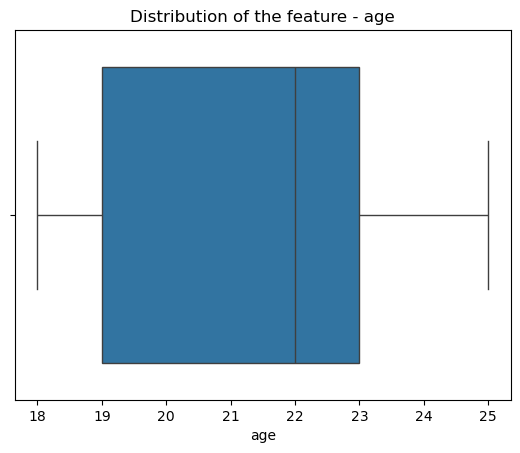

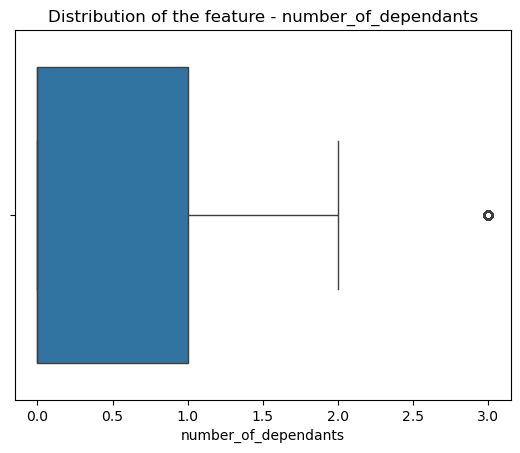

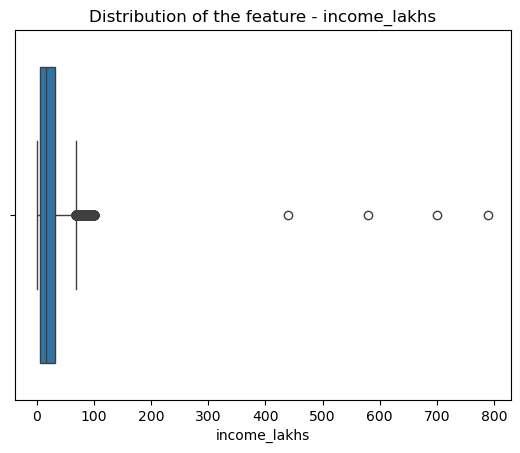

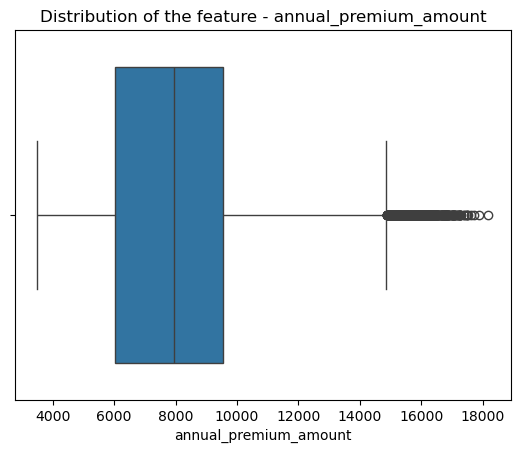

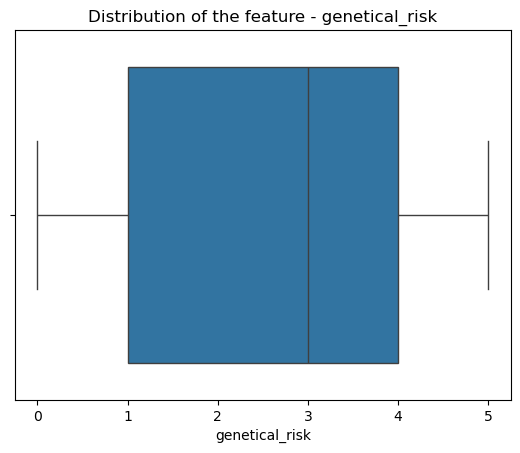

In [142]:
# Plotting box plot for each numerical columns to detect outliers

for col in numeric_columns:
    sns.boxplot(data=df,x=col)
    plt.title(f'Distribution of the feature - {col}')
    plt.show()

As seen above, outliers are present in the `income_lakhs` column. This is also demonstrated by the box plot shown above.

#### Age

In [143]:
# Before
df['age'].unique()

array([18, 22, 21, 25, 20, 19, 23, 24])

In [144]:
# Selecting only the rows where age <= 100. Because age > 100 is outlier

df1 = df[df['age'] <= 100]
df1.reset_index(inplace=True,drop=True)

In [145]:
# After
df1['age'].unique()

array([18, 22, 21, 25, 20, 19, 23, 24])

#### Income

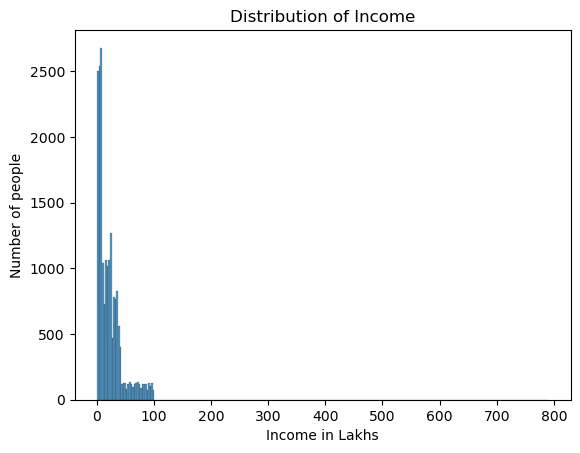

In [146]:
# Distribution of Income using Histogram

sns.histplot(data=df1,x='income_lakhs')
plt.title('Distribution of Income')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

In [147]:
# Determining Lower Salary Boundary and Upper Salary Boundary using IQR Method

# Quartile 1 and Quartile 3

q1 = np.percentile(df1['income_lakhs'],25)
q3 = np.percentile(df1['income_lakhs'],75)
print(f'Q1 -> {q1}\nQ3 -> {q3}')

# Inter Qurartile Range

iqr = q3-q1
print('IQR ->',iqr)

# Lower and Upper boundary using IQR

lower_boundary = q1 - (iqr * 1.5)
upper_boundary = q3 + (iqr * 1.5)
print(f'Lower Boundary -> {lower_boundary}\nUpper Boundary -> {upper_boundary}')

Q1 -> 6.0
Q3 -> 31.0
IQR -> 25.0
Lower Boundary -> -31.5
Upper Boundary -> 68.5


NOTE:

The current upper boundary is too low. Therefore, consultation with the business team will be conducted to determine the optimal upper boundary for identifying outliers in the income_lakhs column.

It has been decided that the upper boundary will be set at 1 crore (i.e., 100 lakhs). Any values exceeding this threshold will be considered outliers.

In [148]:
# Selecting only the rows where income <= 100 lakhs. Because income > 100 lakhs is outlier

income_threshold = 100
df2 = df1[df1['income_lakhs'] <= income_threshold]

In [149]:
df2.reset_index(drop=True,inplace=True)

In [150]:
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603,1
20082,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Diabetes,Gold,14498,2
20083,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,5
20084,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,4


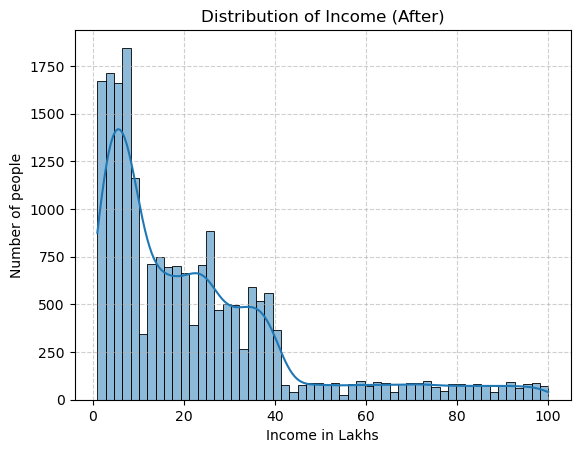

In [151]:
# After Treating outliers in 'income_lakhs' columns

sns.histplot(data=df2,x='income_lakhs',kde=True)
plt.title('Distribution of Income (After)')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## EDA

Exploratory Data Analysis (EDA) is performed as follows:

- Univariate analysis on numeric columns
- Univariate analysis on categorical columns
- Bivariate analysis on numeric columns
- Bivariate analysis on categorical columns

### Univariate Analysis - Numeric Columns

The distribution of numerical columns will be plotted using histograms.

In [152]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

In [153]:
# Number of columns in the grid layout (fixed at 3 columns)
n_cols = 3 

# Calculate the number of rows required for the grid, based on the total number of numeric columns
n_rows = math.ceil(len(numeric_columns)/ n_cols)

# Print the grid dimensions (rows x columns)
print(f"Grid Dimension: {n_rows} rows and {n_cols} columns")

Grid Dimension: 2 rows and 3 columns


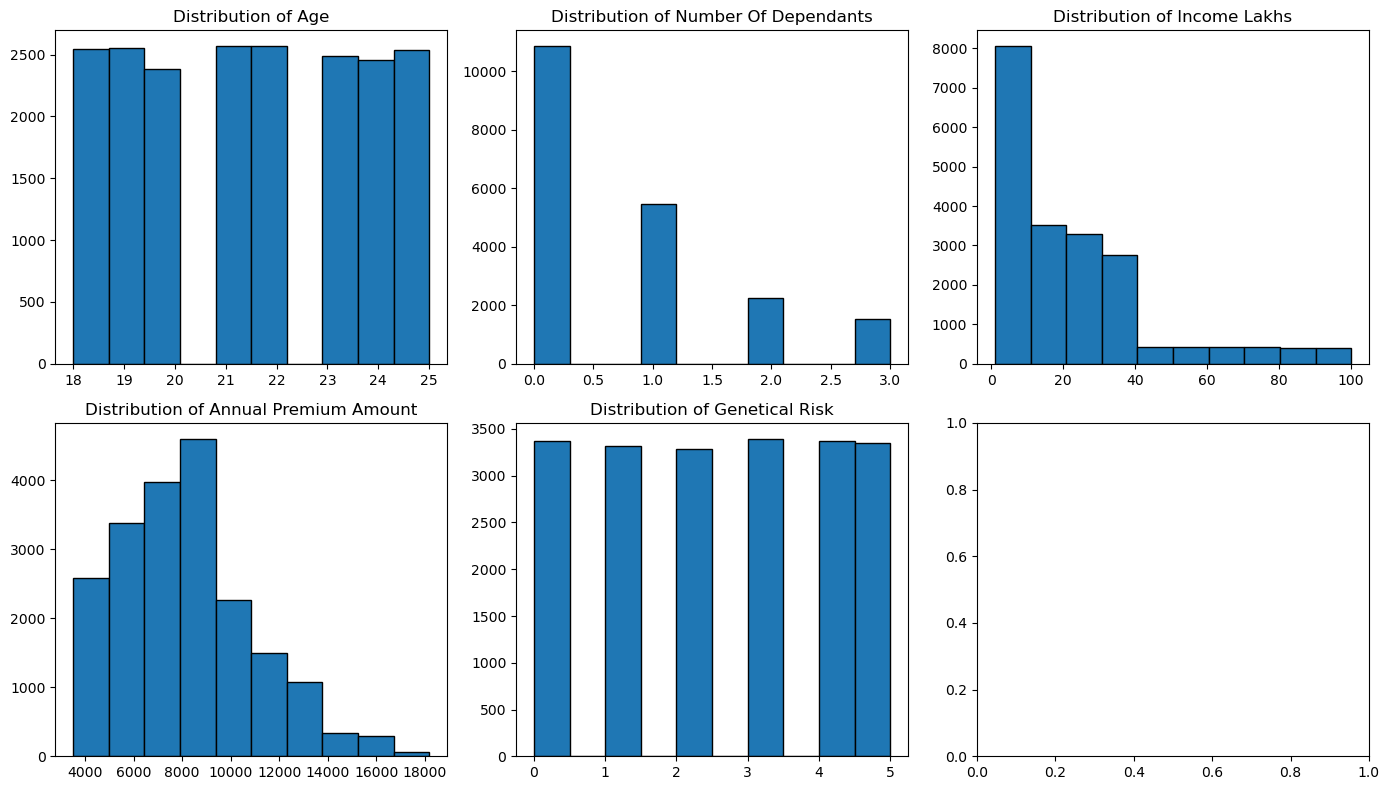

In [154]:
# Create subplots with the specified number of rows and columns
fig , ax = plt.subplots(n_rows,n_cols,figsize=(14,8))

# Flatten the array of axes for easy indexing and plotting
ax = ax.flatten()

# Loop through each numeric column to plot its distribution
for i in range(len(numeric_columns)):
    col = numeric_columns[i]
    # Format column name for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')

    # Plot a histogram for the current numeric column with black edges
    ax[i].hist(x=df2[col],edgecolor='black')

    # Set the title for the subplot to indicate the column being plotted
    ax[i].set_title(f'Distribution of {x_ax}')

# Adjust layout to prevent overlapping labels and ensure proper spacing between plots
plt.tight_layout()
plt.show()

### Univariate Analysis - Categorical Columns

The distribution of categorical columns will be plotted using barcharts.

In [155]:
df2[cat_columns]

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northeast,Unmarried,Overweight,Regular,Self-Employed,> 40L,High blood pressure,Silver
1,Female,Northwest,Unmarried,Underweight,No Smoking,Freelancer,<10L,No Disease,Silver
2,Female,Southeast,Unmarried,Normal,Regular,Salaried,> 40L,No Disease,Silver
3,Male,Southeast,Unmarried,Normal,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
4,Male,Southeast,Unmarried,Overweight,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
...,...,...,...,...,...,...,...,...,...
20081,Female,Southeast,Unmarried,Underweight,No Smoking,Freelancer,> 40L,No Disease,Gold
20082,Female,Northwest,Unmarried,Obesity,Occasional,Freelancer,> 40L,Diabetes,Gold
20083,Female,Northwest,Unmarried,Underweight,No Smoking,Self-Employed,25L - 40L,No Disease,Bronze
20084,Male,Northwest,Unmarried,Normal,Regular,Freelancer,25L - 40L,No Disease,Bronze


In previous runs, the x-axis labels for the `medical_history` column were misaligned in the plots. To resolve this issue, the values will be mapped using the dictionary *ds_dict* as shown below.

In [156]:
ds_dict = {'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

ds_dict

{'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

In [157]:
# Showing how mapping works

print('Without Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index))
print('\n','*'*100,'\n')
print('With Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index.map(ds_dict)))

Without Mapping:
['No Disease', 'Diabetes', 'High blood pressure', 'Thyroid', 'Diabetes & High blood pressure', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Heart disease', 'Diabetes & Heart disease']

 **************************************************************************************************** 

With Mapping:
['NO DISEASE', 'DB', 'HBP', 'THY', 'DB & HBP', 'HBP & HD', 'DB & THY', 'HD', 'DB & HD']


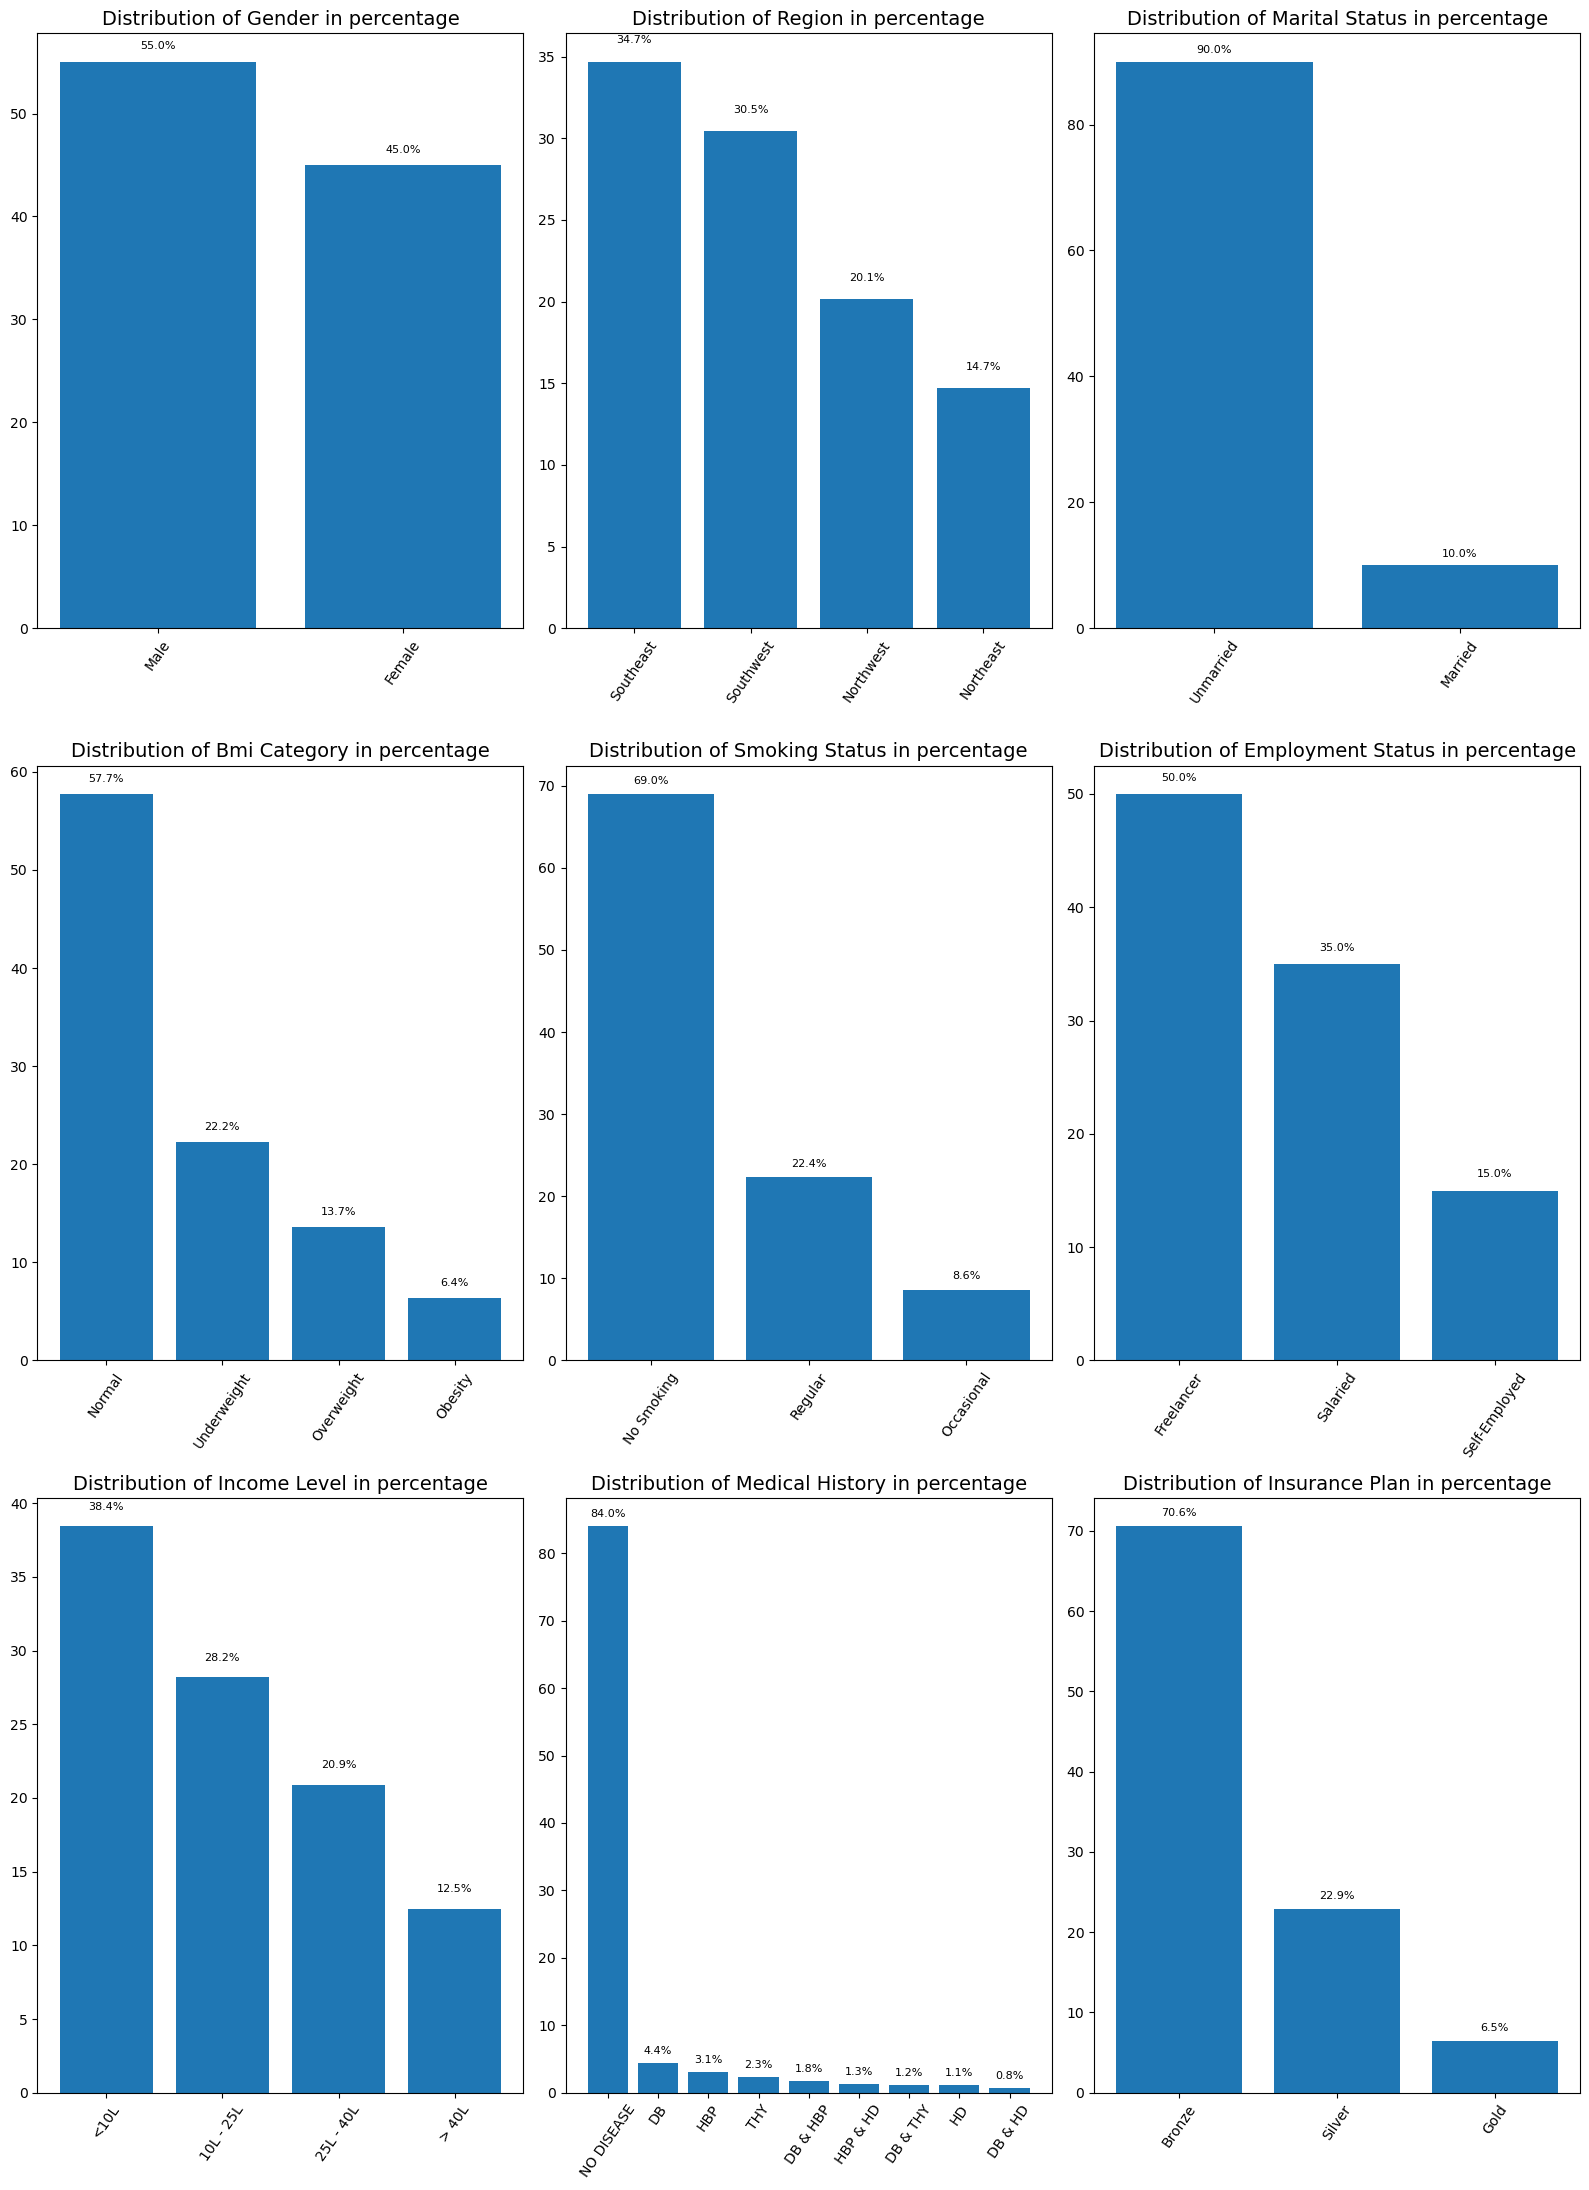

In [158]:
# Plotting Distribution for all categorical columns

fig, ax = plt.subplots(3,3,figsize=(16,22))

# Iterator initiation to retrive one value at a time
it = iter(cat_columns)

for i in range(3):
    for j in range(3):
        # To retrive one value at a time
        col = next(it)
        
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')

        # Map the 'medical_history' column using ds_dict to ensure consistent and clean labels for plotting
        
        if col == 'medical_history':
            x_val = df2[col].value_counts(normalize=True).index.map(ds_dict)
        else:
            x_val = df2[col].value_counts(normalize=True).index
            
        h_val = df2[col].value_counts(normalize=True).values * 100
        ax[i,j].bar(x=x_val,height=h_val)
        ax[i,j].set_title(f'Distribution of {x_ax} in percentage',fontsize=14)
        ax[i,j].tick_params(axis='x', rotation=55)
        
        # Annotate each bar with its corresponding percentage value for better interpretability
        for idx, val in enumerate(h_val):
            ax[i,j].text(idx, val + 1, f'{round(val,1)}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Bivariate Analysis - Numeric Columns

The relationship between each numerical column (excluding the `annual_premium_amount` column itself) and the `annual_premium_amount` column will be plotted to analyze potential correlations.

In [159]:
df2[numeric_columns]

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
0,18,0,99,13365,4
1,22,0,3,11050,3
2,21,0,97,11857,4
3,25,0,15,5684,2
4,20,2,14,5712,1
...,...,...,...,...,...
20081,18,0,91,11603,1
20082,23,0,57,14498,2
20083,24,0,35,9111,5
20084,21,0,32,8564,4


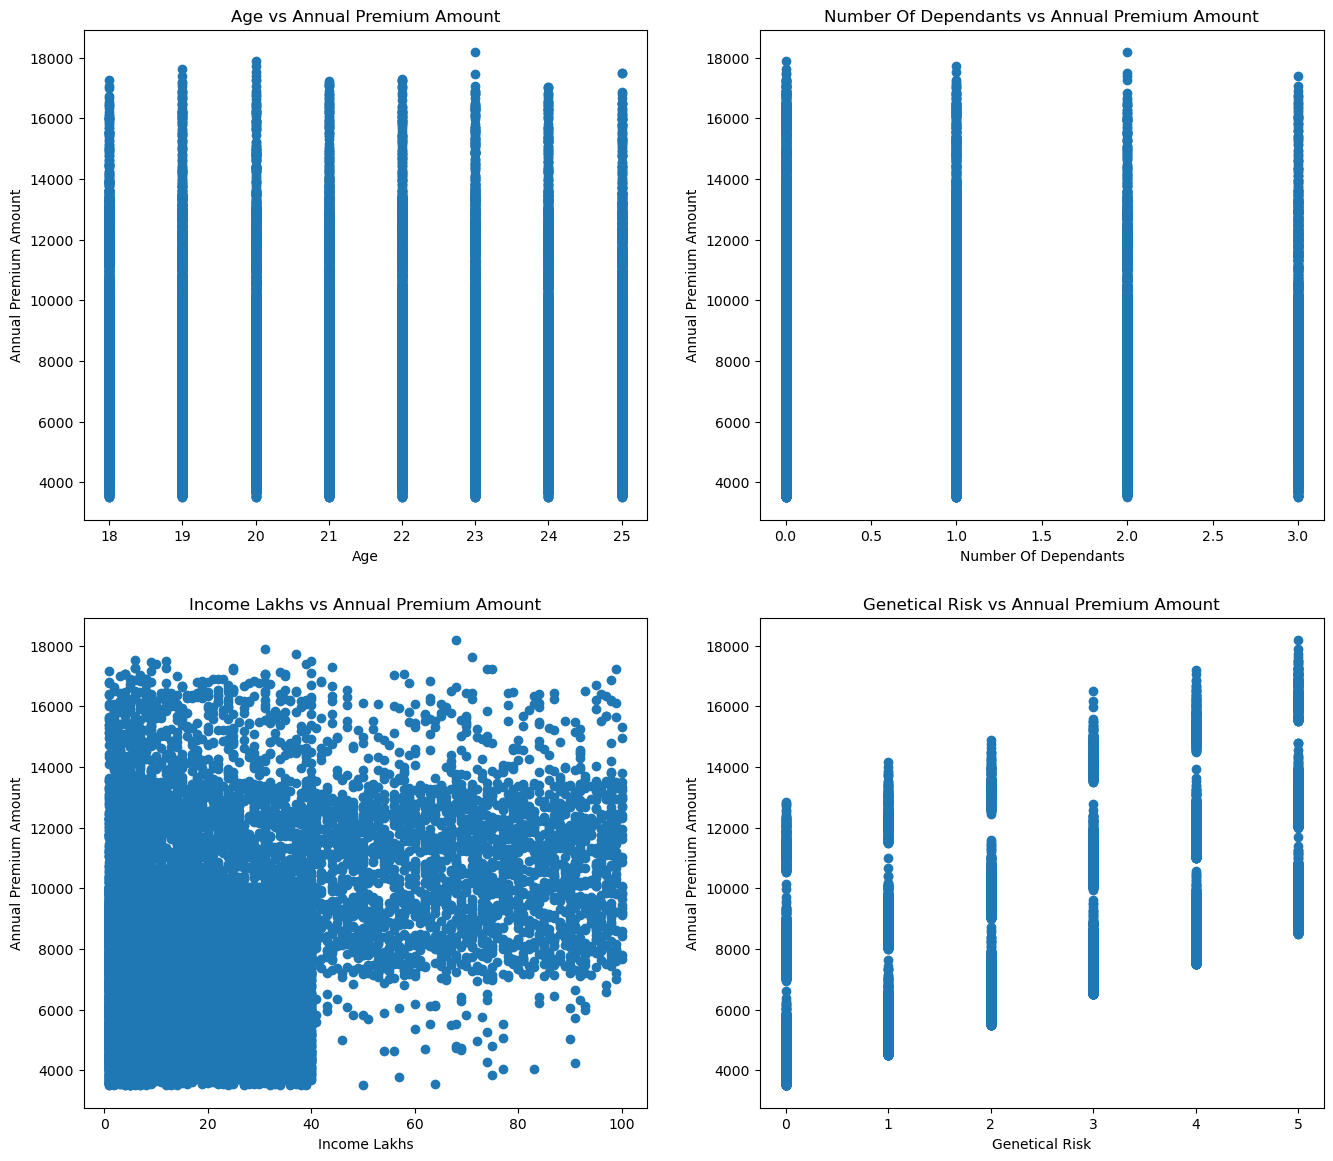

In [160]:
# Plotting the scatter plots

fig, ax = plt.subplots(2,2,figsize=(16,14))

ax=ax.flatten()

temp = list(numeric_columns).remove('annual_premium_amount')

for i in range(len(numeric_columns)-1):
    col = numeric_columns.drop('annual_premium_amount')[i]
    
    # Format column names for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')
    y_ax = 'annual_premium_amount'.title().replace('_',' ')
    
    ax[i].scatter(x=df2[col],y=df2['annual_premium_amount'])
    ax[i].set_title(f'{x_ax} vs {y_ax}')
    ax[i].set_xlabel(x_ax)
    ax[i].set_ylabel(y_ax)

### Bivariate Analysis - Categorical

The relationship between the categorical columns `income_level` and `insurance_plan` will be explored using multiple approaches:

* Cross-tabulation
* Grouped Bar Chart
* Stacked Bar Chart
* Heatmap
  

In [161]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


#### Cross-tabulation

The frequency distribution between `income_level` and `insurance_plan` will be examined using a cross-tabulation, which will display the number of individuals in each combination of income level and insurance plan.

In [162]:
ct = pd.crosstab(df['income_level'],df['insurance_plan'])
ct

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,116,366,2026


In [163]:
# Reorder rows and columns
row_order = ['<10L', '10L - 25L', '25L - 40L', '> 40L']
col_order = ['Bronze', 'Silver', 'Gold']

In [164]:
# Reordered CT

ct = ct.loc[row_order, col_order]
ct

insurance_plan,Bronze,Silver,Gold
income_level,,,
<10L,6172,1145,404
10L - 25L,4508,828,326
25L - 40L,3382,608,209
> 40L,116,2026,366


#### Grouped Bar Chart

The count of each `insurance_plan` across different `income_level` categories will be visualized using grouped bar charts, where each income level will have side-by-side bars representing the different insurance plans for easy comparison.

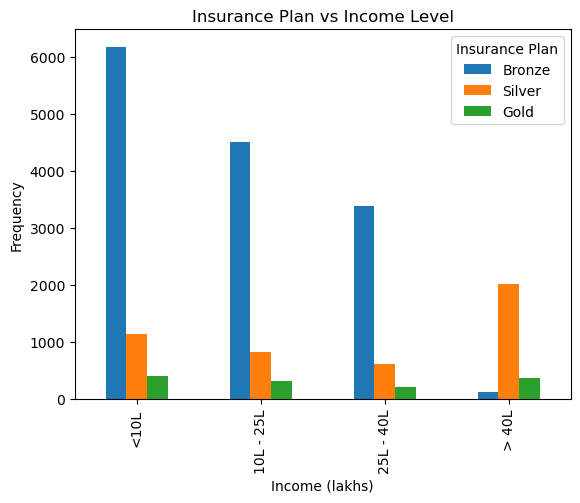

In [165]:
ct.plot(kind='bar')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Stacked Bar Chart

The distribution of `insurance_plan` within each `income_level` will be represented in a stacked bar chart format, helping to understand the proportion of each plan type within the income categories.

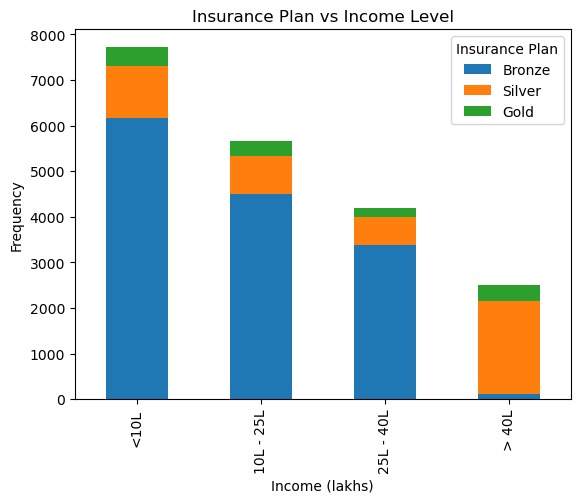

In [166]:
ct.plot(kind='bar',stacked=True)
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Heatmap

The intensity of the relationship between `insurance_plan` and `income_level` will be visualized using a heatmap, where the cells are color-coded based on frequency to highlight patterns and concentrations in the data.

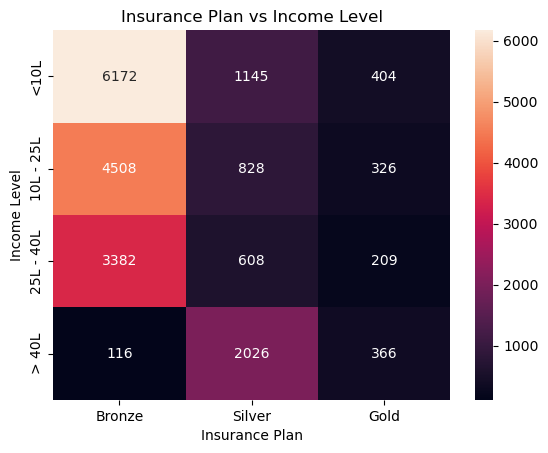

In [167]:
sns.heatmap(ct,annot=True,fmt='0')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.show()

## Feature Engineering

The following feature engineering steps were performed:

- Created new features as required
- Transformed features, including encoding categorical variables
- Selected important features using statistical methods such as Variance Inflation Factor (VIF) and correlation analysis

### Feature Creation - 'total_risk_score'

In this we created a new feature `total_risk_score` from `medical_history` column

In [168]:
# Extract all distinct medical conditions listed in the dataset

df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

The following risk scores, as provided by the business, will be assigned to the corresponding medical conditions:

* Heart disease: 8
* Diabetes: 6
* High blood pressure: 6
* Thyroid: 5
* No Disease: 0
* None: 0

In [169]:
df3 = df2.copy()
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [170]:
# Split the 'medical_history' column into 'disease1' and 'disease2' using '&' as the delimiter

df3[['disease1','disease2']] = df3['medical_history'].str.lower().str.split(' & ',expand=True)
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,None


In [171]:
# Risk Score Dictionary

risk_score_dict = {
    'heart disease' : 8,
'diabetes' : 6,
'high blood pressure' : 6,
'thyroid' : 5,
'no disease' : 0,
None : 0
}

In [172]:
# Mapping each disease to its corresponding score using a predefined dictionary

df3['disease1_score'] = df3['disease1'].map(risk_score_dict)
df3['disease2_score'] = df3['disease2'].map(risk_score_dict)
df3.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,disease1_score,disease2_score
15205,25,Female,Northwest,Unmarried,1,Normal,No Smoking,Salaried,10L - 25L,11,No Disease,Bronze,6170,2,no disease,None,0,0
127,24,Female,Southeast,Unmarried,0,Normal,No Smoking,Salaried,<10L,2,High blood pressure,Silver,11802,4,high blood pressure,None,6,0


In [173]:
# Check if all diseases have been assigned a score and identify any missing values

print('Unique Scores in Disease1 -> ',df3['disease1_score'].unique())
print('Unique Scores in Disease2 -> ',df3['disease2_score'].unique())

Unique Scores in Disease1 ->  [6 0 8 5]
Unique Scores in Disease2 ->  [0 6 8 5]


Since there are no NaN values, it can be concluded that all entries in the `disease1` and `disease2` columns have been successfully mapped.

In [174]:
# Calculating the total risk score by summing 'disease1_score' and 'disease2_score'

df3['total_risk_score'] = df3['disease1_score'] + df3['disease2_score']
df3.sample(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,disease1_score,disease2_score,total_risk_score
19753,19,Female,Northeast,Unmarried,1,Normal,Occasional,Self-Employed,25L - 40L,28,No Disease,Silver,10057,2,no disease,None,0,0,0
18278,20,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,10L - 25L,18,No Disease,Bronze,6371,2,no disease,None,0,0,0
5069,19,Male,Southeast,Unmarried,1,Normal,No Smoking,Freelancer,10L - 25L,19,No Disease,Bronze,3919,0,no disease,None,0,0,0
4494,24,Male,Southeast,Unmarried,0,Overweight,Regular,Salaried,<10L,5,Heart disease,Bronze,10484,4,heart disease,None,8,0,8


The following columns are being dropped as they are no longer needed: `medical_history`, `disease1`, `disease2`, `disease1_score`, and `disease2_score`.

In [175]:
cols_to_drop = ['medical_history', 'disease1', 'disease2', 'disease1_score', 'disease2_score']
df4 = df3.drop(cols_to_drop,axis=1)
df4.reset_index(drop=True,inplace=True)
df4

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,4,6
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,Silver,11050,3,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,Silver,11857,4,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,Bronze,5684,2,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,Bronze,5712,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,Gold,11603,1,0
20082,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Gold,14498,2,6
20083,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,Bronze,9111,5,0
20084,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,Bronze,8564,4,0


### Feature Cleaning & Transformation

The following transformations were applied to the dataset features:

- Label Encoding for ordinal categorical variables (to preserve order)
- One Hot Encodingfor nominal categorical variables (to avoid introducing ordinal relationships)

In [176]:
df5 = df4.copy()
df5.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,4,6
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,Silver,11050,3,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,Silver,11857,4,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,Bronze,5684,2,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,Bronze,5712,1,0


#### Label Encodig - 'income_level'

In [177]:
# Extract all distinct income levels listed in the dataset

df5.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [178]:
# Income level dictionary

income_level_dict =  {
        '<10L' : 1,
        '10L - 25L' : 2,
        '25L - 40L' : 3,
        '> 40L' : 4
    }

In [179]:
# Mapping each income level to a value using a predefined dictionary

df5['income_level'] = df5['income_level'].map(income_level_dict)

In [180]:
# After mapping

df5.income_level.unique()

array([4, 1, 2, 3])

#### Label Encodig - 'insurance_plan'

In [181]:
# Extract all distinct insurance plan listed in the dataset

df5.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [182]:
# Insurance Plan dictionary

insurance_plan_dict = {
        'Bronze' : 1,
        'Silver' : 2,
        'Gold' : 3,
    }

In [183]:
# Mapping each insurance plan to a value using a predefined dictionary

df5['insurance_plan'] = df5['insurance_plan'].map(insurance_plan_dict)

In [184]:
# After mapping

df5.insurance_plan.unique()

array([2, 1, 3])

#### One Hot Encoding

In [185]:
# Selecting columns to perform one hot encoding

cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
cols_to_encode

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']

In [186]:
# Performing One Hot Encoding on df5

df6 = pd.get_dummies(df5,columns = cols_to_encode,dtype=int,drop_first=True)

In [187]:
df6.sample(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1883,21,0,1,6,1,5516,1,0,0,1,0,0,1,1,0,0,0,0,1,0
2710,24,0,3,35,1,10030,5,0,1,1,0,0,1,0,0,0,0,1,0,0
17255,23,0,3,36,1,6745,2,0,1,0,1,0,1,0,0,0,0,1,1,0
19060,20,0,2,24,1,8401,4,0,1,1,0,0,1,1,0,0,0,0,1,0
7535,22,2,1,1,1,8603,5,0,0,0,1,0,1,0,0,1,0,0,1,0


In [188]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20086 entries, 0 to 20085
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              20086 non-null  int64
 1   number_of_dependants             20086 non-null  int64
 2   income_level                     20086 non-null  int64
 3   income_lakhs                     20086 non-null  int64
 4   insurance_plan                   20086 non-null  int64
 5   annual_premium_amount            20086 non-null  int64
 6   genetical_risk                   20086 non-null  int64
 7   total_risk_score                 20086 non-null  int64
 8   gender_Male                      20086 non-null  int64
 9   region_Northwest                 20086 non-null  int64
 10  region_Southeast                 20086 non-null  int64
 11  region_Southwest                 20086 non-null  int64
 12  marital_status_Unmarried         20086 non-nul

In [189]:
# Showing all the non-encoded columns and one encoded columns from each category

sampled_encoded_cols_index = [0,1,2,3,4,5,6,7,8,11,12,15,17]

df6.iloc[0:5,sampled_encoded_cols_index]

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Southwest,marital_status_Unmarried,bmi_category_Underweight,smoking_status_Regular
0,18,0,4,99,2,13365,4,6,1,0,1,0,1
1,22,0,1,3,2,11050,3,0,0,0,1,1,0
2,21,0,4,97,2,11857,4,0,0,0,1,0,1
3,25,0,2,15,1,5684,2,0,1,0,1,0,0
4,20,2,2,14,1,5712,1,0,1,0,1,0,0


### Feature Selection

- To identify the most relevant features, both pairwise correlations and multicollinearity will be analyzed.  
- *Correlation* analysis will be used to detect linear relationships, while *Variance Inflation Factor (VIF)* will be employed to identify multicollinearity.  
- Prior to these analyses, features will be scaled to ensure comparability across variables.

In [190]:
# Before Scaling the features

df7 = df6.copy()
df7.sample(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
15353,24,2,1,8,2,12038,4,0,0,0,1,0,1,0,1,0,0,0,1,0
5731,23,0,1,5,1,6698,3,0,0,0,1,0,1,0,0,1,0,0,1,0
9616,20,0,3,31,3,17878,5,0,1,0,0,0,1,1,0,0,0,1,0,1


In [191]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

The following columns will be scaled: `age`, `number_of_dependants`, `income_level`, `income_lakhs`, `insurance_plan`,`genetical_risk`, `total_risk_score`.  

Scaling type : Minmax scaling

In [192]:
# Scaling using 'MinMaxScaler'

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk', 'total_risk_score']
mms = MinMaxScaler()
df7[cols_to_scale] = mms.fit_transform(df7[cols_to_scale])

#### Correlation

In [193]:
# Correlation Matrix between features

cr = df7.corr()
cr

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.003096,-0.010634,-0.016671,-0.018195,-0.010815,0.005195,0.003074,0.007791,0.002698,-0.003419,0.006922,0.000389,-0.001597,0.022006,-0.003068,-0.011040,-0.009827,-0.009493,0.001680
number_of_dependants,0.003096,1.000000,-0.014268,-0.014835,0.007802,0.005909,-0.008507,0.044009,-0.008213,0.014965,-0.000088,-0.011166,-0.722696,0.004090,0.002822,-0.000630,-0.015309,-0.001891,-0.013320,0.010281
income_level,-0.010634,-0.014268,1.000000,0.908131,0.322278,0.244373,-0.003485,-0.005214,0.026991,-0.003467,-0.003369,0.011454,0.012376,0.011474,0.013096,-0.003746,0.006059,0.000315,-0.111361,0.103160
income_lakhs,-0.016671,-0.014835,0.908131,1.000000,0.380968,0.290683,0.001163,-0.006630,0.000951,-0.006349,-0.004859,0.015674,0.014021,0.014379,0.008312,-0.000598,0.006187,-0.010641,-0.084416,0.083316
insurance_plan,-0.018195,0.007802,0.322278,0.380968,1.000000,0.761004,-0.002717,0.001951,-0.016589,-0.006221,-0.007836,0.013644,-0.006561,0.002285,-0.006236,0.007766,-0.001517,-0.008755,-0.016911,0.026543
annual_premium_amount,-0.010815,0.005909,0.244373,0.290683,0.761004,1.000000,0.619001,0.090702,0.000251,-0.017573,0.002388,0.008090,-0.008706,0.064828,0.036573,0.004972,0.008673,0.085407,-0.015318,0.024136
genetical_risk,0.005195,-0.008507,-0.003485,0.001163,-0.002717,0.619001,1.000000,-0.006758,-0.007633,-0.019909,0.014583,-0.004539,0.003134,-0.001069,0.000284,0.010509,0.006400,0.004686,-0.003772,0.004591
total_risk_score,0.003074,0.044009,-0.005214,-0.006630,0.001951,0.090702,-0.006758,1.000000,-0.000234,-0.000102,-0.008037,-0.004214,-0.056335,0.001278,0.000108,-0.010735,-0.008724,0.003557,-0.005101,-0.002150
gender_Male,0.007791,-0.008213,0.026991,0.000951,-0.016589,0.000251,-0.007633,-0.000234,1.000000,-0.002796,-0.000131,-0.002445,0.009276,-0.061257,0.043389,-0.060075,0.053469,0.202788,0.006978,-0.001052
region_Northwest,0.002698,0.014965,-0.003467,-0.006349,-0.006221,-0.017573,-0.019909,-0.000102,-0.002796,1.000000,-0.365912,-0.332236,-0.009604,-0.010099,0.003283,0.003720,-0.000543,-0.002375,0.010613,0.000254


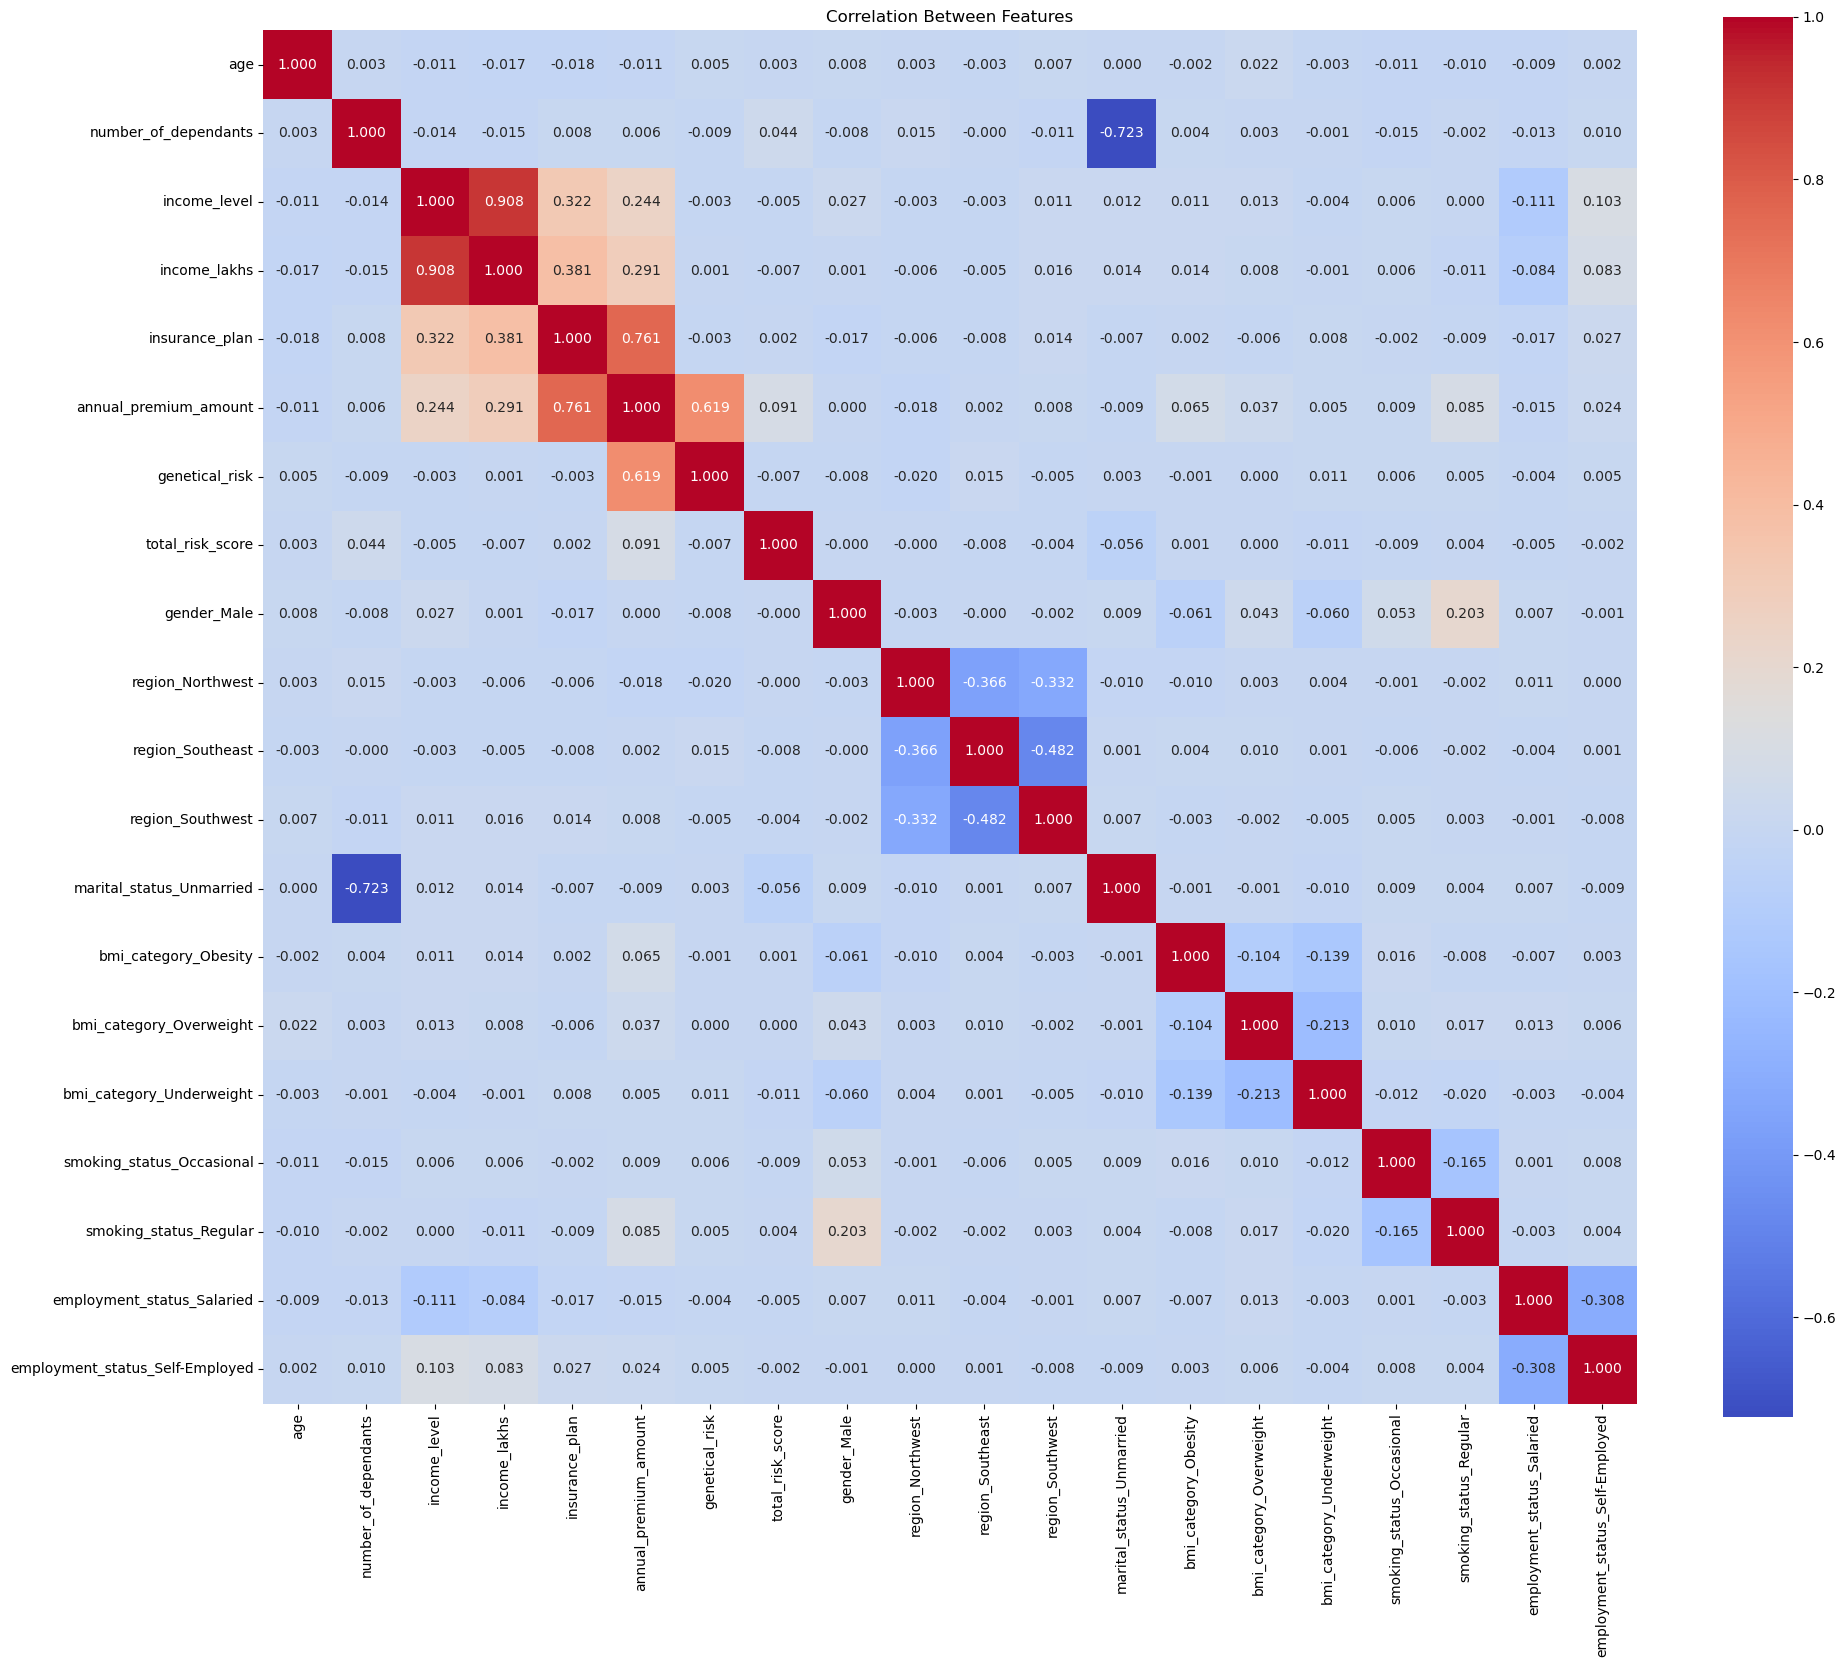

In [194]:
# Correlation Matrix displayed as a Heatmap

plt.figure(figsize=(20,20))
sns.heatmap(cr, annot=True, fmt='.3f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

In [195]:
# Display features that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount']

income_level             0.244373
income_lakhs             0.290683
insurance_plan           0.761004
annual_premium_amount    1.000000
genetical_risk           0.619001
Name: annual_premium_amount, dtype: float64

In [196]:
# Extract the feature names (index labels) that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount'].index

Index(['income_level', 'income_lakhs', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

**Observation**

Based on the correlation heatmap, a ***strong positive correlation*** with `annual_premium_amount` is observed for the features `income_level`, `income_lakhs`, `insurance_plan` and `genetical_risk` suggesting that these variables may significantly influence premium prediction.

***No strong negative correlation was observed***, indicating that no variables show a clear inverse relationship with premium amounts.

#### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) will be checked to detect and address multicollinearity among the features.


In [197]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [198]:
# Calculate VIF for each feature and store the results in a new DataFrame

# Initialize a dictionary to store feature names and their corresponding VIF scores
vif_dict = {'features':[],'vif_score':[]}

# Exclude the target variable from VIF calculation
temp_df = df7.drop('annual_premium_amount',axis=1)

# Loop through each feature to compute VIF
for i,col in enumerate(temp_df.columns):
    # Calculate the Variance Inflation Factor for the current feature
    vif = variance_inflation_factor(temp_df,i)

    # Append the feature name and its VIF score to the dictionary
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

In [199]:
# Convert the VIF dictionary into a DataFrame for better readability and analysis
vif_df = pd.DataFrame(vif_dict)

# Sort features by their VIF scores in descending order to identify highly collinear features
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
2,income_level,11.928708
3,income_lakhs,11.876413
11,marital_status_Unmarried,8.011790
0,age,3.154599
9,region_Southeast,2.990493
5,genetical_risk,2.981159
10,region_Southwest,2.744620
7,gender_Male,2.311831
8,region_Northwest,2.154355
1,number_of_dependants,1.930428


After the Variance Inflation Factor (VIF) was calculated for all features, it was observed that both `income_level` and `income_lakhs` had VIF scores exceeding the commonly accepted threshold of 10, indicating the presence of high multicollinearity between them.

To address this issue and enhance model stability, the `income_level` feature was dropped, as it exhibited the higher VIF value of the two. This step was taken to reduce redundancy without significantly compromising the information contained in the dataset.

In [200]:
# Initialize a list to store highly collinear features to be removed later

high_vif_features  = []

In [201]:
# Identify the feature with the highest VIF score and add it to the removal list 'high_vif_features'

highest_vif_feature = vif_df['features'][vif_df['vif_score'].idxmax()]
high_vif_features.append(highest_vif_feature)
print(high_vif_features)

['income_level']


In [202]:
# Drop the most collinear feature from the temporary DataFrame

temp_df1 = temp_df.drop(['income_level'],axis=1).copy()
temp_df1

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,0.000000,0.000000,0.909091,1.0,0.2,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20082,0.714286,0.000000,0.565657,1.0,0.4,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20083,0.857143,0.000000,0.343434,0.0,1.0,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20084,0.428571,0.000000,0.313131,0.0,0.8,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


The same process will be repeated until all VIF values are within the acceptable threshold.

In [203]:
# Recalculate VIF scores for the updated feature set

vif_dict = {'features':[],'vif_score':[]}

for i,col in enumerate(temp_df1.columns):
    vif = variance_inflation_factor(temp_df1,i)
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

# Create a DataFrame from the updated VIF scores
vif_df = pd.DataFrame(vif_dict)

# Sort VIF scores in descending order to identify next candidates for removal
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
10,marital_status_Unmarried,7.985337
0,age,3.153255
8,region_Southeast,2.989301
4,genetical_risk,2.981158
9,region_Southwest,2.743932
6,gender_Male,2.301658
2,income_lakhs,2.294155
7,region_Northwest,2.153423
1,number_of_dependants,1.927788
16,employment_status_Salaried,1.668660


All remaining features have acceptable VIF scores.

In [204]:
# Remove the previously identified high-VIF features from the original DataFrame.
final_df = df7.drop(high_vif_features,axis=1)

# Display the final cleaned dataset
final_df

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,13365,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,11050,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,11857,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,5684,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,5712,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20081,0.000000,0.000000,0.909091,1.0,11603,0.2,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20082,0.714286,0.000000,0.565657,1.0,14498,0.4,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20083,0.857143,0.000000,0.343434,0.0,9111,1.0,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20084,0.428571,0.000000,0.313131,0.0,8564,0.8,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


## Exporting Processed Data

In [205]:
# Define ouput path

folder = config_yaml_datasource['root_folder']
sub_folder = config_yaml_datasource['folders']['processed']
file = config_yaml_datasource['files']['young_gr']['processed_name']

output_path = os.path.abspath(os.path.join(project_root,folder,sub_folder,file))
output_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_predictor\\data\\processed\\premiums_young_processed_with_gr.csv'

In [206]:
# Storing the processed data as a file

final_df.to_csv(output_path,header=True,index=False)

## Model Selection

The model selection process proceeded as follows:

1. Split the dataset into training and test sets.  
2. Trained different models on the training data.  
3. Used cross-validation to compare model performance.  
4. Tuned hyperparameters of the best model.  
5. Evaluated the final model’s performance on the test set. 

### Dataset Split

The dataset is divided as follows:

- Training set: 70%
- Test set: 30%

Split was done randomly with a fixed seed for reproducibility.

In [207]:
# Separate features and target variable

features = final_df.drop(['annual_premium_amount'],axis=1)
target = final_df['annual_premium_amount']

In [208]:
# Split the data into training and test sets

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=42)

In [209]:
# Display the shape of training and test sets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14060, 18), y_train shape: (14060,)
X_test shape: (6026, 18), y_test shape: (6026,)


### Model Training

Various models will be tried and training will be performed, including:

* Linear Regression  
* Ridge Regression  
* Lasso Regression  
* Random Forest Regressor  
* XGBoost Regressor

#### Linear Regression

In [210]:
# Initialize and train the Linear Regression model
lr=LinearRegression()
lr.fit(X_train,y_train)

# Evaluate model performance
train_score = lr.score(X_train,y_train)
test_score = lr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9884990017445308 , Test Score : 0.9882609305654483 


In [211]:
# Predict on test data
y_pred = lr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 89439.7314526086 , RMSE : 299.06476130197717


In [212]:
# Feature Names and Its Coefficents

print('Features -> ',lr.feature_names_in_)
print('\n','**'*50)
print('Coef -> ',lr.coef_)

Features ->  ['age' 'number_of_dependants' 'income_lakhs' 'insurance_plan'
 'genetical_risk' 'total_risk_score' 'gender_Male' 'region_Northwest'
 'region_Southeast' 'region_Southwest' 'marital_status_Unmarried'
 'bmi_category_Obesity' 'bmi_category_Overweight'
 'bmi_category_Underweight' 'smoking_status_Occasional'
 'smoking_status_Regular' 'employment_status_Salaried'
 'employment_status_Self-Employed']

 ****************************************************************************************************
Coef ->  [-1.05801891e-01  2.01069306e+01 -1.18192939e+01  6.99564576e+03
  4.98367534e+03  1.13118985e+03  6.08209851e+00  1.91642829e+00
  2.07974087e+00  8.29849020e+00  1.42155309e+01  8.01977884e+02
  4.04437286e+02  1.13743592e+02  2.07656492e+02  6.07368444e+02
  7.08985789e+00  9.30425482e+00]


In [213]:
# Creating a dataframe of features and coefficients

feat_coef = {
    'features' : lr.feature_names_in_,
    'coef' : lr.coef_
}

feat_coef_df = pd.DataFrame(feat_coef)
feat_coef_df.sort_values(by=['coef'],ascending=False)

,features,coef
3,insurance_plan,6995.645756
4,genetical_risk,4983.675336
5,total_risk_score,1131.189849
11,bmi_category_Obesity,801.977884
15,smoking_status_Regular,607.368444
12,bmi_category_Overweight,404.437286
14,smoking_status_Occasional,207.656492
13,bmi_category_Underweight,113.743592
1,number_of_dependants,20.106931
10,marital_status_Unmarried,14.215531


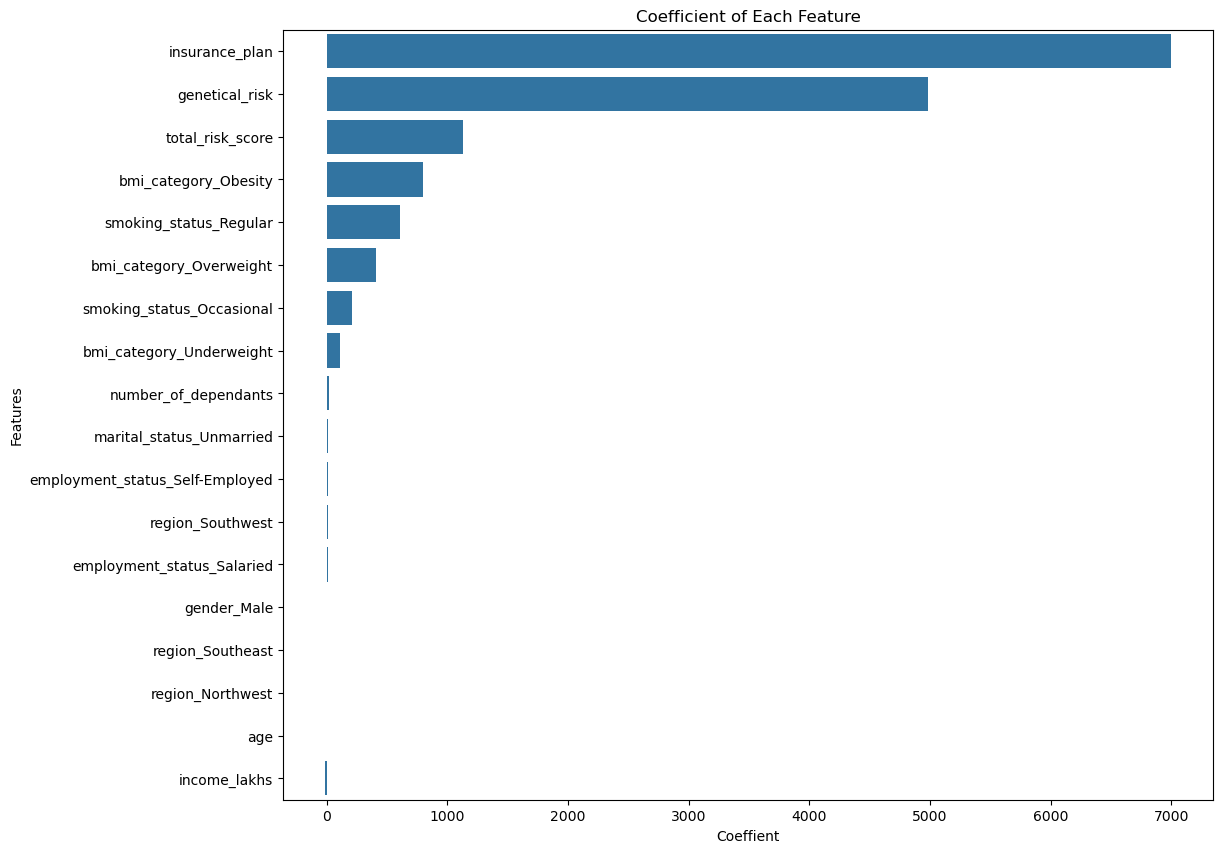

In [214]:
# Plotting the features and its coefficients

plt.figure(figsize=(12,10))
sns.barplot(data=feat_coef_df.sort_values(by=['coef'],ascending=False),x = 'coef',y = 'features' )
plt.title('Coefficient of Each Feature')
plt.xlabel('Coeffient')
plt.ylabel('Features')
plt.show()

#### Lasso Regression

In [215]:
# Initialize and train the Lasso Regression model
ls = Lasso()
ls.fit(X_train,y_train)

# Evaluate model performance
train_score = ls.score(X_train,y_train)
test_score = ls.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9884791726215936 , Test Score : 0.9882674685993185 


In [216]:
# Predict on test data
y_pred = ls.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 89389.91830542267 , RMSE : 298.9814681638691


#### Ridge Regression

In [217]:
# Initialize and train the Ridge Regression model
rg = Ridge()
rg.fit(X_train,y_train)

# Evaluate model performance
train_score = rg.score(X_train,y_train)
test_score = rg.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.988498397209062 , Test Score : 0.9882566783127196 


In [218]:
# Predict on test data
y_pred = rg.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 89472.12927973195 , RMSE : 299.1189216344094


**Observation**

Neither Lasso nor Ridge regression showed significant improvement over Linear Regression.

#### Random Forest Regressor

In [219]:
# Initialize and train the Random Forest Regression model
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

# Evaluate model performance
train_score = rfr.score(X_train,y_train)
test_score = rfr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9980577375479447 , Test Score : 0.9860361303721622 


In [220]:
# Predict on test data
y_pred = rfr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 106390.43891137419 , RMSE : 326.1754725778353


#### XGboost Regressor

In [221]:
# Initialize and train the XGboost model
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

# Evaluate model performance
train_score = xgb.score(X_train,y_train)
test_score = xgb.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9926241040229797 , Test Score : 0.9874040484428406 


In [222]:
# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 95968.5 , RMSE : 309.787841796875


**Model Performance Comparison: Linear Regression vs Random Forest vs XGBoost**

Strong performance was demonstrated by all three models - Linear Regression, Random Forest, and XGBoost - on the dataset. Notably:

- **Linear Regression** was found to achieve a **lower training score** and a **higher test score** compared to the other models.
- It is suggested that Linear Regression **generalizes better** and is potentially **less prone to overfitting**.
- In contrast, higher training scores were exhibited by both Random Forest and XGBoost, suggesting that overfitting may have occurred.

To validate these observations, **cross-validation** will be performed using `cross_validate` to assess the models more robustly across multiple folds and ensure consistent performance.


### Cross Validation - LR vs RF vs XGB

Cross-validation will be performed on Linear Regression, Random Forest and XGBoost models, with the run time also being recorded.  
The `cross_validate` function is used instead of `cross_val_score` to obtain both training and testing scores.

Stratified K-Fold will not be performed since this is a regression task; therefore, K-Fold cross-validation is considered sufficient.

In [223]:
# Set up 5-fold cross-validation

kf = KFold(n_splits = 5,shuffle=True,random_state=42)

In [224]:
# Perform cross-validation for Linear Regression

start_time = time()
cv_lr = cross_validate(lr,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_lr = end_time - start_time
print(f'Total Time Taken : {round(total_time_lr,2)} seconds')

Total Time Taken : 0.09 seconds


In [225]:
# Display training scores
print("Training scores (R²):", cv_lr['train_score'])

# Display test scores
print("Validation scores (R²):", cv_lr['test_score'])

Training scores (R²): [0.98852002 0.98839467 0.98835287 0.98849817 0.98841899]
Validation scores (R²): [0.98807182 0.98857609 0.98874716 0.98815524 0.98848721]


In [226]:
# Perform cross-validation for Random Forest Regressor

start_time = time()
cv_rfr = cross_validate(rfr,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_rfr = end_time - start_time
print(f'Total Time Taken : {round(total_time_rfr,2)} seconds')

Total Time Taken : 23.16 seconds


In [227]:
# Display training scores
print("Training scores (R²):", cv_rfr['train_score'])

# Display test scores
print("Validation scores (R²):", cv_rfr['test_score'])

Training scores (R²): [0.99806277 0.99803466 0.99803261 0.99803514 0.99804585]
Validation scores (R²): [0.98613303 0.98637283 0.98682347 0.98645678 0.98619252]


In [228]:
# Perform cross-validation for XGboost Regressor

start_time = time()
cv_xgb = cross_validate(xgb,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_xgb = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb,2)} seconds')

Total Time Taken : 0.71 seconds


In [229]:
# Display training scores
print("Training scores (R²):", cv_xgb['train_score'])

# Display test scores
print("Validation scores (R²):", cv_xgb['test_score'])

Training scores (R²): [0.9924103  0.99234444 0.9922235  0.99225652 0.99228865]
Validation scores (R²): [0.98730546 0.9878037  0.98817861 0.98732311 0.9876461 ]


In [230]:
cv_df = pd.DataFrame(
    {
        'model' : ['Linear Regression','Random Forest','XGboost'],
        'execution_time (seconds)' : [total_time_lr,total_time_rfr,total_time_xgb],
        'average_train_score' : [np.mean(cv_lr['train_score']),np.mean(cv_rfr['train_score']),np.mean(cv_xgb['train_score'])],
        'average_test_score' : [np.mean(cv_lr['test_score']),np.mean(cv_rfr['test_score']),np.mean(cv_xgb['test_score'])]
    }
)

cv_df

,model,execution_time (seconds),average_train_score,average_test_score
0,Linear Regression,0.087917,0.988437,0.988408
1,Random Forest,23.159676,0.998042,0.986396
2,XGboost,0.714873,0.992305,0.987651


**Cross-Validation Summary: Linear Regression vs Random Forest vs XGBoost**

The cross-validation results confirm that **Linear Regression** consistently generalizes better than both *Random Forest* and *XGBoost* models:

- Lower training scores and higher test scores were achieved by Linear Regression, indicating **better generalization** and **reduced overfitting**.
- In terms of performance, Linear Regression was approximately **240 times faster** than Random Forest and **4 times faster** than XGBoost during cross-validation.

Given its superior predictive performance and computational efficiency, **Linear Regression will be selected as the final model**.

### Hyperparameter Tuning

The **Linear Regression** model will be fine-tuned using `GridSearchCV`, as it has a smaller number of hyperparameters compared to models like Random Forest or XGBoost.

While **GridSearchCV** explores all possible hyperparameter combinations exhaustively, the relatively small hyperparameter space for **Linear Regression** makes this approach efficient and feasible.

#### GridSearchCV

In [231]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [232]:
param_grid_dict = {
    'copy_X' : [True, False],
    'fit_intercept' : [True, False],
    'positive' : [True, False], 
}

In [233]:
# Initialize GridSearchCV

gscv = GridSearchCV(estimator=lr,param_grid=param_grid_dict,cv=kf,scoring ='r2')

In [234]:
# Executing GridSearchCV and Timing the search

start_time = time()
gscv.fit(features,target)
end_time = time()
total_time_xgb_hyp = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb_hyp,2)} seconds')

Total Time Taken : 0.73 seconds


#### Best Model

In [235]:
# Displaying the results of GridSearchCV execution

pd.DataFrame(gscv.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027650,0.003754,0.002623,0.000563,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'posit...",0.988073,0.988574,0.988745,0.988157,0.988495,0.988409,0.000255,1
4,0.021055,0.001560,0.002357,0.000350,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'posi...",0.988073,0.988574,0.988745,0.988157,0.988495,0.988409,0.000255,1
1,0.009022,0.001117,0.002362,0.000577,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'posit...",0.988072,0.988576,0.988747,0.988155,0.988487,0.988408,0.000256,3
5,0.006140,0.000896,0.001858,0.000153,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'posi...",0.988072,0.988576,0.988747,0.988155,0.988487,0.988408,0.000256,3
2,0.022892,0.000981,0.002120,0.000028,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'posi...",0.940658,0.938206,0.940324,0.937424,0.941088,0.939540,0.001450,5
3,0.007724,0.001025,0.002056,0.000509,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'posi...",0.940658,0.938206,0.940324,0.937424,0.941088,0.939540,0.001450,5
6,0.020595,0.000487,0.001887,0.000165,False,False,True,"{'copy_X': False, 'fit_intercept': False, 'pos...",0.940658,0.938206,0.940324,0.937424,0.941088,0.939540,0.001450,5
7,0.004895,0.000262,0.001545,0.000034,False,False,False,"{'copy_X': False, 'fit_intercept': False, 'pos...",0.940658,0.938206,0.940324,0.937424,0.941088,0.939540,0.001450,5


In [236]:
# Best score we get from the Tuning

gscv.best_score_

np.float64(0.9884090026140072)

In [237]:
# Parameters that gave the best score

gscv.best_params_

{'copy_X': True, 'fit_intercept': True, 'positive': True}

In [238]:
# Model that resulted the best score

best_model = gscv.best_estimator_
best_model

LinearRegression(positive=True)

### Performance of the 'Best Model'

The best model’s performance was evaluated on the test set to assess its real-world effectiveness.

#### Scores

In [239]:
# Evaluate Best model's performance
train_score = best_model.score(X_train,y_train)
test_score = best_model.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9884914055365249 , Test Score : 0.9882984618741419 


The best model's training and test scores are improved after adding 'genetical_risk' feature.  

In [240]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics of the best model
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 89153.78117440814 , RMSE : 298.58630439859115


#### Features and their Importance

The contribution of each feature to the model's predictions was analyzed.

In [241]:
# Retrieve feature names used during model training (available after fitting)

best_model.feature_names_in_

array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'total_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype=object)

In [242]:
# Feature importance scores from the fitted model

best_model.coef_

array([0.00000000e+00, 1.27213450e+01, 0.00000000e+00, 6.99614775e+03,
       4.99330878e+03, 1.11553932e+03, 6.19891060e+00, 6.63050650e+00,
       3.38816391e+00, 8.93699433e+00, 3.00789426e+00, 8.07166707e+02,
       4.02286563e+02, 1.07955484e+02, 1.99427129e+02, 6.07463378e+02,
       3.76744035e+00, 2.88743491e+00])

In [243]:
# Create a DataFrame of features and their corresponding importance scores
feat_coef_df = pd.DataFrame(
    {
        'features' : best_model.feature_names_in_,
        'importance' : best_model.coef_
    }
)

# Sort the features by importance in descending order
feat_coef_df = feat_coef_df.sort_values(by=['importance'],ascending=False)
feat_coef_df

,features,importance
3,insurance_plan,6996.147752
4,genetical_risk,4993.308780
5,total_risk_score,1115.539321
11,bmi_category_Obesity,807.166707
15,smoking_status_Regular,607.463378
12,bmi_category_Overweight,402.286563
14,smoking_status_Occasional,199.427129
13,bmi_category_Underweight,107.955484
1,number_of_dependants,12.721345
9,region_Southwest,8.936994


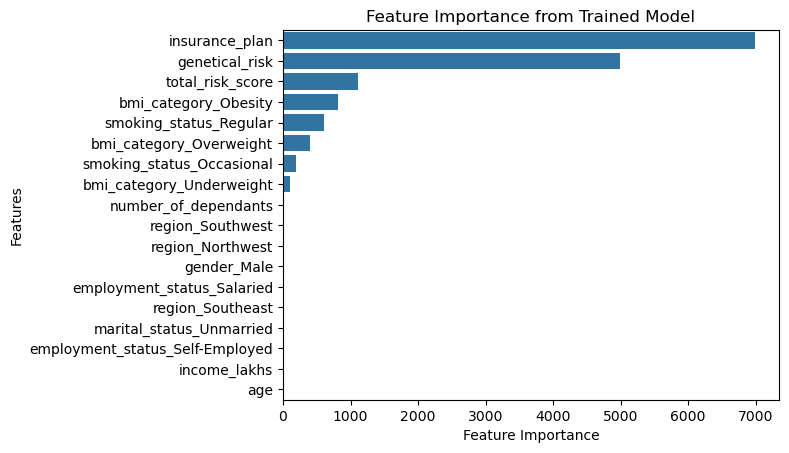

In [244]:
# Plot feature importances using a horizontal bar chart
sns.barplot(data = feat_coef_df, x='importance',y='features')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Trained Model")
plt.show()

## Error Anlysis

The prediction errors (residuals) will be analyzed to evaluate the model’s performance.

**Objective:**  
Ensure that 95% of incorrect predictions deviate by ≤10% from the actual values.

**Approach:**  
- Residuals will be calculated as: residual = actual − predicted  
- Percentage error relative to actual values will be computed.  
- The proportion of errors falling within the 10% threshold will be checked.  
- Any consistent error patterns across customer segments will be identified.

In [245]:
# Predict on test data

y_pred = best_model.predict(X_test)

In [246]:
# Check the shape of predictions and actual test labels to ensure alignment

print("Predicted labels shape:", y_pred.shape)
print("Actual labels shape:", y_test.shape)

Predicted labels shape: (6026,)
Actual labels shape: (6026,)


### Residuals 

The difference between the predicted values and the actual values will be determined.

In [247]:
# Calculate residuals (difference between predicted and actual values)
residuals = y_pred - y_test

# Display the residuals
residuals

10480     26.441406
7981    -546.898742
3111    -303.314947
10596    -17.538174
4202     459.586034
            ...    
18950   -294.043549
266      105.416039
10027   -387.913017
15496     75.155525
10881    -97.700331
Name: annual_premium_amount, Length: 6026, dtype: float64

In [248]:
# Calculate the residual percentage
# What it shows? - How much the predicted value is deviated from the actual value
# 2.68 -> Predicted Value is 2.68% higher than the actual value
# -1.5 -> Predicted Value is 1.5% lower than the actual value

residuals_pct = ((y_pred - y_test) / y_test)*100
residuals_pct

10480     0.484985
7981     -5.662650
3111     -5.029265
10596    -0.141597
4202     10.826526
           ...    
18950    -6.849372
266       0.886669
10027    -3.266361
15496     0.559484
10881    -1.150770
Name: annual_premium_amount, Length: 6026, dtype: float64

Everything will be put into a dataframe for better understanding.

In [249]:
# Create a dictionary to store actual, predicted, residuals, and residual percentages
residual_dict = {
    'actual' : y_test,
    'predicted' : y_pred,
    'residual' : residuals,
    'residual_pct' : residuals_pct
}

# Convert the dictionary into a DataFrame for easier analysis
residual_df = pd.DataFrame(residual_dict)

# Display the DataFrame
residual_df

,actual,predicted,residual,residual_pct
10480,5452,5478.441406,26.441406,0.484985
7981,9658,9111.101258,-546.898742,-5.662650
3111,6031,5727.685053,-303.314947,-5.029265
10596,12386,12368.461826,-17.538174,-0.141597
4202,4245,4704.586034,459.586034,10.826526
...,...,...,...,...
18950,4293,3998.956451,-294.043549,-6.849372
266,11889,11994.416039,105.416039,0.886669
10027,11876,11488.086983,-387.913017,-3.266361
15496,13433,13508.155525,75.155525,0.559484


In [250]:
# Sort the residual_df by residual_pct in descending order to see the largest errors first

residual_df.sort_values(by=['residual_pct'],ascending=False)

,actual,predicted,residual,residual_pct
2973,3503,4005.155362,502.155362,14.335009
10156,3501,4002.723891,501.723891,14.330874
19809,3512,4000.417404,488.417404,13.907101
12049,3503,3989.167172,486.167172,13.878595
14205,3514,4001.495860,487.495860,13.872961
...,...,...,...,...
10876,8076,7029.039034,-1046.960966,-12.963855
18785,5426,4626.618213,-799.381787,-14.732432
17808,5438,4634.626102,-803.373898,-14.773334
12484,5493,4641.880494,-851.119506,-15.494621


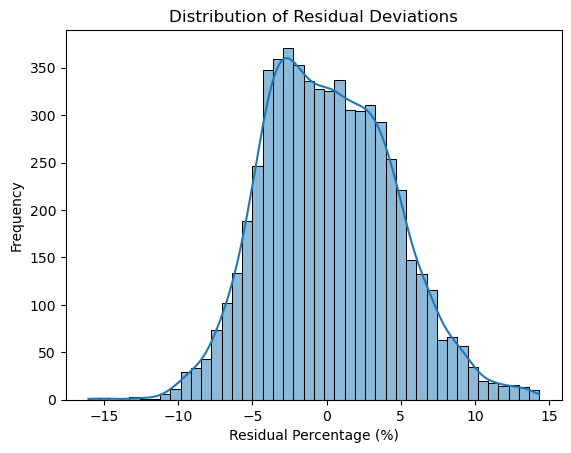

In [251]:
# Plot the distribution of residual percentages with a Kernel Density Estimate (KDE) overlay
sns.histplot(data = residual_df, x = 'residual_pct',kde=True )
plt.title('Distribution of Residual Deviations')
plt.xlabel('Residual Percentage (%)')
plt.ylabel('Frequency')
plt.show()

The model's predicted values are within **-15% to 15%** of the actual values. Further checks will be performed to confirm the model’s performance remains within this acceptable range.

### Analysing Extreme Residuals

As stated in the Statement of Work (SOW):

- The goal is to ensure that 95% of incorrect predictions deviate by no more than 10% from the actual values.

This implies that even when predictions are incorrect, **95%** of them should exhibit **less than 10% deviation** - either above or below the actual values.

In other words, only **5%** of incorrect predictions are permitted to deviate by **more than 10%** from the actual values.

Based on this requirement, the deviation threshold has been set at **10%**.

In [252]:
# Acceptable percentage deviation allowed between actual and expected values

deviation_pct = 10

In [253]:
# Filter rows where the absolute residual percentage exceeds the deviation_pct (10%)
extreme_residual = residual_df[abs(residual_df['residual_pct']) > deviation_pct]

# Display a random sample of 2 such extreme residuals for inspection
extreme_residual.sample(2)

,actual,predicted,residual,residual_pct
2973,3503,4005.155362,502.155362,14.335009
18941,3820,4299.437220,479.437220,12.550713


In [254]:
# Get the number of rows and columns in the filtered DataFrame (extreme residuals)
extreme_residual.shape

(119, 4)

In [255]:
# Get the number of rows and columns in the original residual DataFrame
residual_df.shape

(6026, 4)

In [256]:
# Calculate the percentage of residuals that exceed the deviation_pct
extreme_residual_percentage = (extreme_residual.shape[0] / residual_df.shape[0])*100

# Display the calculated percentage
extreme_residual_percentage

1.9747759707932293

### Final Verdict

It was observed that about **2%** of the predicted values differ by more than **10%** from the actual values, which is below the allowed **5%** threshold.

This confirms that the model meets the **deviation constraint** specified in the SOW.

Therefore, the model performed well on the subset of data where **age <= 25**.


## Export Artifacts

In [257]:
model_artifacts = {
    'model_data': {
                    'trained_model' : best_model,
                    'feature_names' : best_model.feature_names_in_
                    },
    'scaler_data' : {
                    'scaler_object' : mms,
                    'scaled_columns' : cols_to_scale
                    } 
    }

In [258]:
project_root

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_predictor'

In [259]:
# Extracting only Data Source details
config_yaml_artifacts = config_yaml['artifacts']    
print(config_yaml_artifacts)

{'root_folder': 'artifacts', 'files': {'young': 'insurance_premium_pipeline_young.joblib', 'rest': 'insurance_premium_pipeline_rest.joblib'}}


In [260]:
# Define datasource path

folder = config_yaml_artifacts['root_folder']
file = config_yaml_artifacts['files']['young']

artifact_save_path = os.path.abspath(os.path.join(project_root,folder,file))
artifact_save_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_predictor\\artifacts\\insurance_premium_pipeline_young.joblib'

In [261]:
try:
    joblib.dump(model_artifacts, artifact_save_path)
    print(f"Saved artifacts successfully at {artifact_save_path}")
except Exception as e:
    print(f"Error saving artifacts: {e}")

Saved artifacts successfully at C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_predictor\artifacts\insurance_premium_pipeline_young.joblib
